### DESCRIPTION:
    Ask your Analytical DB (Azure Data Explorer aka Kusto) questions in English – generate KQL (Kusto Query language) from the user’s input using OpenAI GPT3.5 turbo model then query Azure Data Explorer (Kusto) using the generated KQL.
    
### REQUIREMENTS:
* Create an .env file with your OpenAI API key and save it in the root directory of this project with the following
    OPENAI_DEPLOYMENT_ENDPOINT ="<your openai endpoint>"   
    OPENAI_API_KEY = "<your openai api key>"  
    OPENAI_DEPLOYMENT_NAME = "<your gpt35 deployment name>"  
    OPENAI_DEPLOYMENT_VERSION = "<gpt35 api version>"  
    OPENAI_MODEL_NAME="<gpt35 model name>"  
  
* Install an Azure Data Explorer cluster, create a DB called retail and a table called sales by ingesting the data in:
     An ADX (Azure Data Explorer or Kusto) cluster  
    In ADX, create a Database named "openai"  
        <img src="images/1.png" alt="Create Kusto cluster" /> 
    Create a table called "sales" by ingesting data from "./data/analytics/Warehouse_and_Retail_Sales.csv"   
        <img src="images/2.png" alt="Create Kusto cluster" /> 
    Create an AAD app registration for Authentication - see below   
        [Create an Azure Active Directory application registration in Azure Data Explorer](https://learn.microsoft.com/en-us/azure/data-explorer/provision-azure-ad-app)

    Update the environment variables in the .env file:
    AAD_TENANT_ID = "<your aad tenant id>"  
    KUSTO_CLUSTER =  "https://<your azure data explorer name>.westeurope.kusto.windows.net"  
    KUSTO_DATABASE = "<your kusto database name>"  
    KUSTO_TABLE = "sales"  
    KUSTO_MANAGED_IDENTITY_APP_ID = "<your aad app registration id>"  
    KUSTO_MANAGED_IDENTITY_SECRET = "<your kusto managed identity secret>"  

In [16]:
from azure.kusto.data import KustoClient, KustoConnectionStringBuilder
from azure.kusto.data.exceptions import KustoServiceError
from azure.kusto.data.helpers import dataframe_from_result_table
from dotenv import load_dotenv
import utils
import pandas as pd
import os
import openai
import json 

load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY") 
OPENAI_DEPLOYMENT_ENDPOINT = os.getenv("OPENAI_DEPLOYMENT_ENDPOINT")
OPENAI_DEPLOYMENT_NAME = os.getenv("OPENAI_DEPLOYMENT_NAME")
OPENAI_MODEL_NAME = os.getenv("OPENAI_MODEL_NAME")
OPENAI_DEPLOYMENT_VERSION = os.getenv("OPENAI_DEPLOYMENT_VERSION")
# Configure OpenAI API
openai.api_type = "azure"
openai.api_version = OPENAI_DEPLOYMENT_VERSION
openai.api_base = OPENAI_DEPLOYMENT_ENDPOINT
openai.api_key = OPENAI_API_KEY

AAD_TENANT_ID = os.getenv("AAD_TENANT_ID")
KUSTO_CLUSTER = os.getenv("KUSTO_CLUSTER")
KUSTO_DATABASE = os.getenv("KUSTO_DATABASE")
KUSTO_TABLE = os.getenv("KUSTO_TABLE")
KUSTO_MANAGED_IDENTITY_APP_ID = os.getenv("KUSTO_MANAGED_IDENTITY_APP_ID")
KUSTO_MANAGED_IDENTITY_SECRET = os.getenv("KUSTO_MANAGED_IDENTITY_SECRET")

In [17]:
print(OPENAI_DEPLOYMENT_NAME)

gpt35


In [2]:
# Connect to adx using AAD app registration
cluster = KUSTO_CLUSTER
kcsb = KustoConnectionStringBuilder.with_aad_application_key_authentication(cluster, KUSTO_MANAGED_IDENTITY_APP_ID, KUSTO_MANAGED_IDENTITY_SECRET,  AAD_TENANT_ID)
client = KustoClient(kcsb)

In [3]:
# Test the connection to kusto works - sample query to get the top 10 results from the sales table
query = "sales | take 10"

response = client.execute("AzureOpenAiTest", query)
for row in response.primary_results[0]:
    print("Item:{}".format(row["item_description"]))

Item:BOOTLEG RED - 750ML
Item:MOMENT DE PLAISIR - 750ML
Item:S SMITH ORGANIC PEAR CIDER - 18.7OZ
Item:SCHLINK HAUS KABINETT - 750ML
Item:SANTORINI GAVALA WHITE - 750ML
Item:CORTENOVA VENETO P/GRIG - 750ML
Item:SANTA MARGHERITA P/GRIG ALTO - 375ML
Item:JACK DANIELS COUNTRY COCKTAIL SOUTHERN PEACH - 10.OZ-NR
Item:KNOB CREEK BOURBON 9YR - 100P - 375ML
Item:KSARA CAB - 750ML


In [4]:
# Create a prompt for the model to generate the KQL query
kusto_query_template_prefix = """
<|im_start|>system
I have an Azure Data Explorer (Kusto) table containing the following columns: 
year, month, supplier, item_code, item_description,item_type,retail_sales,retail_transfers,warehouse_sales

Write an KQL query based on the user input below. Answer in a concise manner. Answer only with the KQL query where the table name is T, no extra text.

user input: 
"""
template_sufix = "<|im_end|>\n<|im_start|>assistant"

In [5]:
# Define functions to call the OpenAI API and run KQL query
def call_openai(template_prefix, text):
    prompt = template_prefix + text + template_sufix
    response = openai.Completion.create(
        engine=utils.OPENAI_DEPLOYMENT_NAME,
        prompt=prompt,
        temperature=0,
        max_tokens=4096,
        top_p=0.95,
        frequency_penalty=0,
        presence_penalty=0,
        stop=["<|im_end|>"])
    response = response['choices'][0]['text']
    response = utils.remove_chars("\n", response)
    response=utils.start_after_string("Answer:", response)
    response=utils.remove_tail_tags("<|im_end|>", response)
    return response

def call_openai_kql_response(text):
    response = call_openai(kusto_query_template_prefix, text)
    query = response.replace("T", "sales")
    query = query.replace("```", "")
    response = client.execute("AzureOpenAiTest", query)
    df = dataframe_from_result_table(response.primary_results[0])
    return df

In [6]:
# Test the model with a sample question - aggregate the retail sales by month for the year 2020
df = call_openai_kql_response("I would like to get the total retail sales for 2020 by months")
print(df)

InvalidRequestError: Resource not found

In [7]:
%debug

> c:\users\wadela\appdata\roaming\python\python311\site-packages\openai\api_requestor.py(765)_interpret_response_line()
    763         stream_error = stream and "error" in resp.data
    764         if stream_error or not 200 <= rcode < 300:
--> 765             raise self.handle_error_response(
    766                 rbody, rcode, resp.data, rheaders, stream_error=stream_error
    767             )

ipdb> OPENAI_DEPLOYMENT_NAME
*** NameError: name 'OPENAI_DEPLOYMENT_NAME' is not defined
ipdb> print(OPENAI_DEPLOYMENT_NAME)
*** NameError: name 'OPENAI_DEPLOYMENT_NAME' is not defined
--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user


In [8]:
# Use plotly to visualize the results
import plotly.express as px

fig = px.bar(df, x = 'month', y = 'total_retail_sales')
fig.show()


NameError: name 'df' is not defined

In [26]:
# Generate KQL and run - aggregate the retail sales by supplier - get the top 10 
df = call_openai_kql_response("I would like to get the top 10 suppliers by total retail sales")
print(df)

                   supplier  total_retail_sales
0        E & J GALLO WINERY           166170.53
1  DIAGEO NORTH AMERICA INC            145343.2
2      CONSTELLATION BRANDS           131664.79
3        ANHEUSER BUSCH INC           109960.82
4        JIM BEAM BRANDS CO            96164.04
5    MILLER BREWING COMPANY            87156.44
6             CROWN IMPORTS            84437.66
7                SAZERAC CO            70414.62
8           BACARDI USA INC            66610.23
9            THE WINE GROUP            64270.04


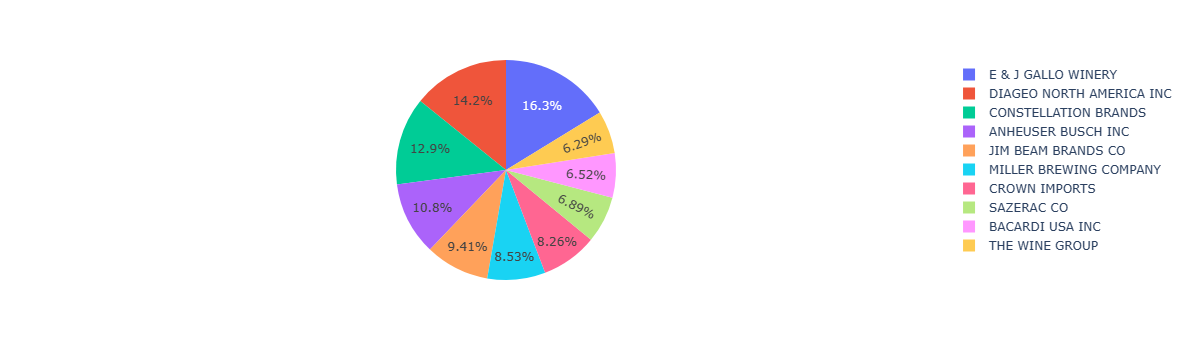

In [27]:
# Use plotly to visualize the results
import plotly.express as px

fig = px.pie(df, names = 'supplier', values = 'total_retail_sales')
fig.show()

In [17]:
# Generate KQL and run 
df = call_openai_kql_response("I would like to get the total retail sales by year and month for the top 10 suppliers")
print(df)

   year  month  total_retail_sales
0  2017     12            28119.88
1  2020      3            15822.92
2  2019     11             7959.42
3  2019      5             7935.54
4  2017      6             7863.66
5  2019      3             7529.03
6  2017      7             7438.81
